Calculating Topographic Features (Slope & Aspect)...


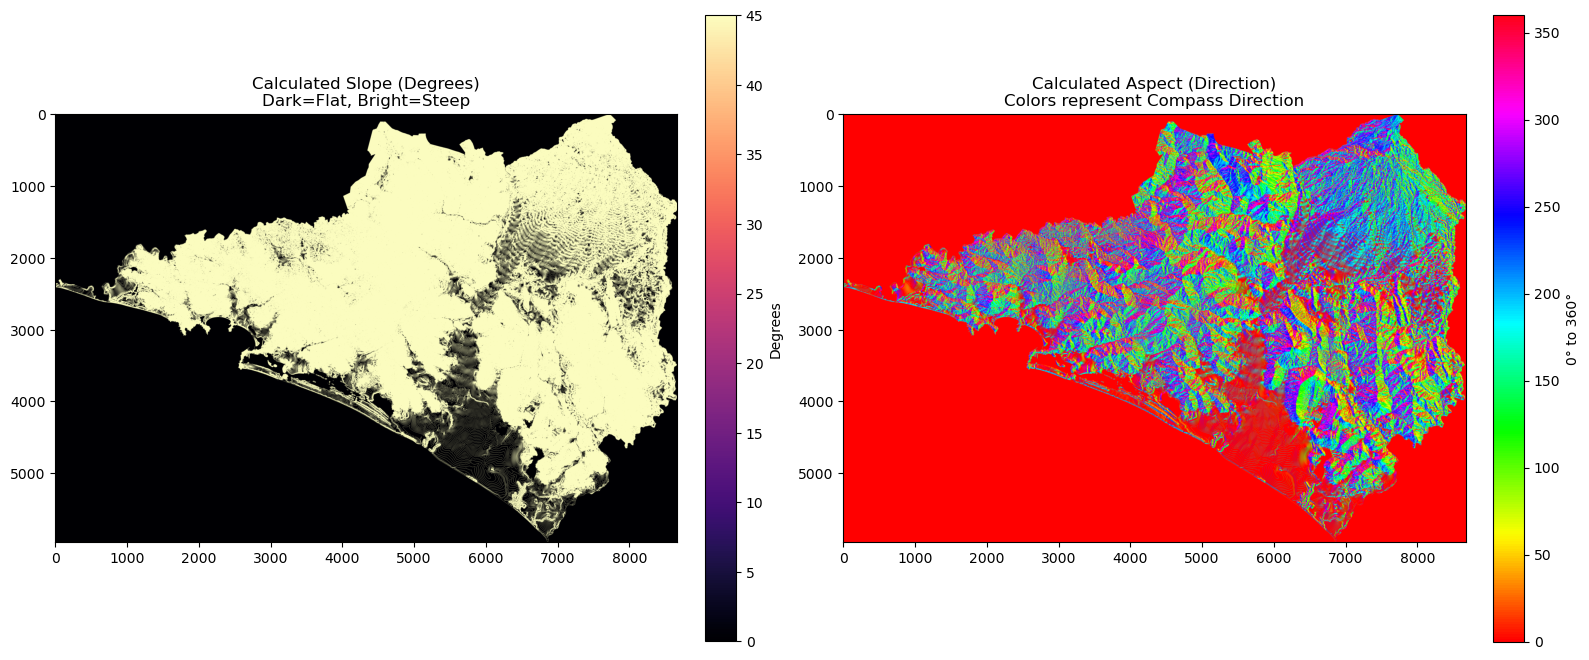

✅ Calculation Complete.
Max Slope Detected: 90.00 degrees


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# --- CONFIGURATION ---
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"

def calculate_slope_aspect(dem_path):
    with rasterio.open(dem_path) as src:
        elevation = src.read(1)
        
        # 1. Define cell size (Resolution)
        # We know from the metadata it's roughly 15m, but we calculate it exactly from the transform
        cell_size_x = src.transform[0]
        cell_size_y = -src.transform[4] # Typically negative in GeoTIFFs
        
        # 2. Calculate Gradients (The Math of "Steepness")
        # np.gradient calculates the difference between neighbor pixels
        dy, dx = np.gradient(elevation, cell_size_y, cell_size_x)
        
        # 3. Calculate Slope (in Degrees)
        # Slope is the hypotenuse of the change in X and Y
        slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
        slope_deg = np.degrees(slope_rad)
        
        # 4. Calculate Aspect (Direction 0-360)
        # 0=North, 90=East, 180=South, 270=West
        aspect_rad = np.arctan2(-dx, dy) # Note the negative sign logic for geographic orientation
        aspect_deg = np.degrees(aspect_rad)
        # Convert -180/180 range to 0-360 range
        aspect_deg = (aspect_deg + 360) % 360
        
        return elevation, slope_deg, aspect_deg, src.bounds

# --- EXECUTION ---
print("Calculating Topographic Features (Slope & Aspect)...")
elevation, slope, aspect, bounds = calculate_slope_aspect(inegi_path)

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot Slope
im1 = ax1.imshow(slope, cmap='magma', vmin=0, vmax=45) # 45 degrees is very steep
ax1.set_title("Calculated Slope (Degrees)\nDark=Flat, Bright=Steep")
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label="Degrees")

# Plot Aspect
im2 = ax2.imshow(aspect, cmap='hsv', vmin=0, vmax=360)
ax2.set_title("Calculated Aspect (Direction)\nColors represent Compass Direction")
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label="0° to 360°")

plt.tight_layout()
plt.show()

print(f"✅ Calculation Complete.")
print(f"Max Slope Detected: {np.max(slope):.2f} degrees")

Opening Satellite Archive and Calculating NDVI...
Red Band Found: S2B_MSIL2A_20240501T171859_N0510_R012_T13QEB_20240501T214403.SAFE/GRANULE/L2A_T13QEB_A037361_20240501T173111/IMG_DATA/R10m/T13QEB_20240501T171859_B04_10m.jp2
NIR Band Found: S2B_MSIL2A_20240501T171859_N0510_R012_T13QEB_20240501T214403.SAFE/GRANULE/L2A_T13QEB_A037361_20240501T173111/IMG_DATA/R10m/T13QEB_20240501T171859_B08_10m.jp2


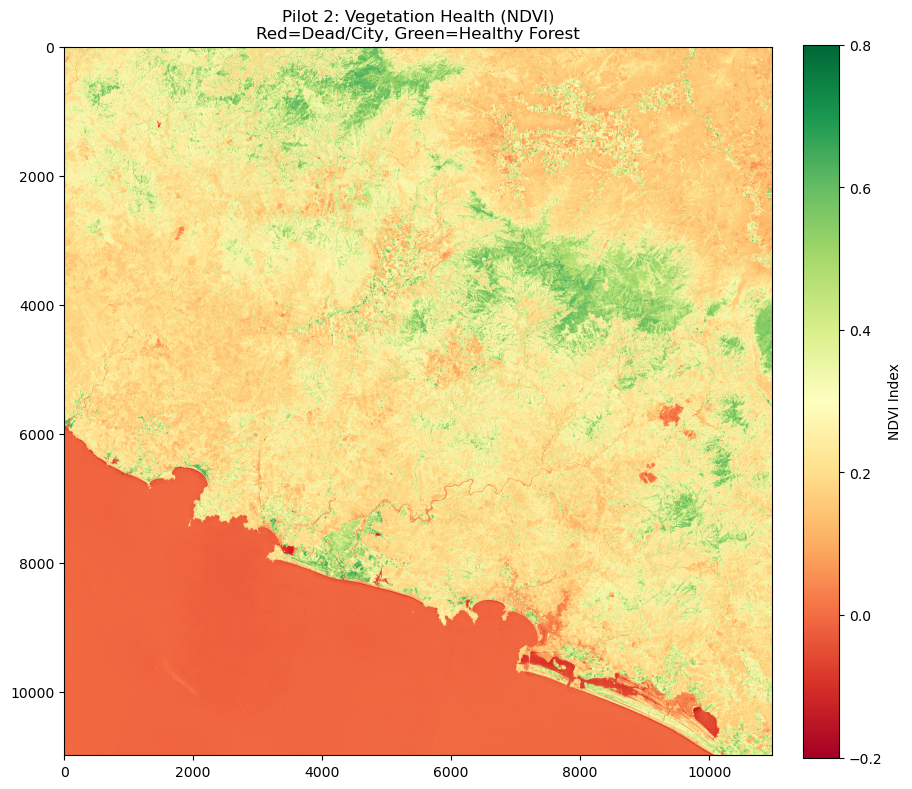

✅ NDVI Calculation Complete.
Mean Vegetation Score: 0.20


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

# --- CONFIGURATION ---
sentinel_dir = "../data/raw/sentinel/"
# Auto-find the zip file
zip_name = [f for f in os.listdir(sentinel_dir) if f.endswith('.zip')][0]
zip_path = os.path.join(sentinel_dir, zip_name)

def calculate_ndvi(zip_path):
    # We use a "Virtual File System" prefix (/vsizip/) so Rasterio can read inside the zip
    # We need to find the correct internal paths for Band 4 (Red) and Band 8 (NIR)
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        # List all files inside
        all_files = z.namelist()
        
        # Find the 10m resolution files for Band 4 and Band 8
        # Sentinel logic: Look for 'B04' and 'B08' inside the 'R10m' folder
        red_file = [f for f in all_files if "B04" in f and "10m" in f][0]
        nir_file = [f for f in all_files if "B08" in f and "10m" in f][0]
        
        print(f"Red Band Found: {red_file}")
        print(f"NIR Band Found: {nir_file}")
        
        # Construct the full virtual path
        red_full_path = f"/vsizip/{zip_path}/{red_file}"
        nir_full_path = f"/vsizip/{zip_path}/{nir_file}"
        
        # Open and Read
        with rasterio.open(red_full_path) as src_red:
            red = src_red.read(1).astype('float32')
            meta = src_red.profile
            
        with rasterio.open(nir_full_path) as src_nir:
            nir = src_nir.read(1).astype('float32')
            
        # Calculate NDVI
        # Formula: (NIR - Red) / (NIR + Red)
        # Avoid division by zero by using a small epsilon or numpy handling
        numerator = nir - red
        denominator = nir + red
        
        # Handle division by zero (create a mask)
        ndvi = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
        
        return ndvi, meta

# --- EXECUTION ---
print("Opening Satellite Archive and Calculating NDVI...")
ndvi_map, meta = calculate_ndvi(zip_path)

# --- VISUALIZATION ---
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
# -1 = Water/Clouds (Blue/Black)
# 0 = Concrete/Rock (Yellow/Brown)
# 1 = Dense Healthy Forest (Deep Green)
im = ax.imshow(ndvi_map, cmap='RdYlGn', vmin=-0.2, vmax=0.8)

ax.set_title(f"Pilot 2: Vegetation Health (NDVI)\nRed=Dead/City, Green=Healthy Forest")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="NDVI Index")
plt.show()

print(f"✅ NDVI Calculation Complete.")
print(f"Mean Vegetation Score: {np.mean(ndvi_map):.2f}")

In [2]:
import rasterio
from rasterio.warp import transform
import pandas as pd
import numpy as np
import os
import zipfile

# --- CONFIGURATION ---
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"
conafor_path = "../data/raw/conafor_infys/INFyS_2015_2020_Colima_qM0XXKR.xlsx"
sentinel_dir = "../data/raw/sentinel/"
sentinel_zip = [f for f in os.listdir(sentinel_dir) if f.endswith('.zip')][0]
zip_path = os.path.join(sentinel_dir, sentinel_zip)

# --- HELPER: SAMPLING FUNCTION ---
def sample_raster(raster_data, transform, x, y):
    row, col = rasterio.transform.rowcol(transform, x, y)
    if 0 <= row < raster_data.shape[0] and 0 <= col < raster_data.shape[1]:
        return raster_data[row, col]
    return np.nan

# --- EXECUTION ---

print("1. Loading Forest Sites...")
df = pd.read_excel(conafor_path)
if 'Y_C3' in df.columns: lat_col, lon_col = 'Y_C3', 'X_C3'
else: lat_col, lon_col = 'Latitud', 'Longitud'

df = df.dropna(subset=[lat_col, lon_col])
df.loc[df[lat_col] > 100, lat_col] /= 1000000.0
df.loc[df[lon_col] < -200, lon_col] /= 1000000.0

print("2. Calibrating Slope (Fixing the 90-degree bug)...")
with rasterio.open(inegi_path) as src:
    dem_data = src.read(1)
    dem_transform = src.transform
    
    # --- THE FIX: Convert Pixel Size from Degrees to Meters ---
    # Get pixel size in degrees (e.g., 0.000138)
    px_deg = src.transform[0]
    py_deg = -src.transform[4] 
    
    # Approximation: 1 degree Lat ~= 111,120 meters
    # Manzanillo is roughly 19.1 degrees North
    mid_lat_radians = np.radians(19.1)
    meters_per_deg_lat = 111120
    meters_per_deg_lon = 111120 * np.cos(mid_lat_radians)
    
    # Calculate pixel size in real meters
    px_meters = px_deg * meters_per_deg_lon
    py_meters = py_deg * meters_per_deg_lat
    
    # Calculate Slope using METERS, not DEGREES
    dy, dx = np.gradient(dem_data, py_meters, px_meters)
    slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
    slope_map = np.degrees(slope_rad)
    
    # Harvest Elevation & Slope
    df['Elevation_m'] = df.apply(lambda row: sample_raster(dem_data, dem_transform, row[lon_col], row[lat_col]), axis=1)
    df['Slope_deg'] = df.apply(lambda row: sample_raster(slope_map, dem_transform, row[lon_col], row[lat_col]), axis=1)

print("3. Harvesting Satellite NDVI...")
with zipfile.ZipFile(zip_path, 'r') as z:
    all_files = z.namelist()
    red_file = [f for f in all_files if "B04" in f and "10m" in f][0]
    nir_file = [f for f in all_files if "B08" in f and "10m" in f][0]
    
    with rasterio.open(f"/vsizip/{zip_path}/{red_file}") as src_sat:
        sat_transform = src_sat.transform
        sat_crs = src_sat.crs
        
        # Reproject Points to Match Satellite
        lons = df[lon_col].values
        lats = df[lat_col].values
        xs_utm, ys_utm = transform('EPSG:4326', sat_crs, lons, lats)
        df['UTM_X'] = xs_utm
        df['UTM_Y'] = ys_utm

        # Calculate NDVI
        red = src_sat.read(1).astype('float32')
        with rasterio.open(f"/vsizip/{zip_path}/{nir_file}") as src_nir:
            nir = src_nir.read(1).astype('float32')
            
        numerator = nir - red
        denominator = nir + red
        ndvi_map = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
        
        # Harvest
        df['NDVI'] = df.apply(lambda row: sample_raster(ndvi_map, sat_transform, row['UTM_X'], row['UTM_Y']), axis=1)

# 4. SAVE
final_df = df.dropna(subset=['Elevation_m', 'NDVI'])
save_path = "../data/processed/manzanillo_training_data.csv"
os.makedirs("../data/processed", exist_ok=True)
final_df.to_csv(save_path, index=False)

print("-" * 30)
if len(final_df) > 0:
    print(f"✅ SUCCESS! Valid Data: {len(final_df)} sites.")
    print(f"   Mean Slope: {final_df['Slope_deg'].mean():.1f} degrees (Target: 5-40 deg)")
    print(f"   Mean NDVI:  {final_df['NDVI'].mean():.2f}")
else:
    print("❌ FAILURE: 0 sites.")
print("-" * 30)
print(final_df[['Elevation_m', 'Slope_deg', 'NDVI']].head())

1. Loading Forest Sites...
2. Calibrating Slope (Fixing the 90-degree bug)...
3. Harvesting Satellite NDVI...
------------------------------
✅ SUCCESS! Valid Data: 19 sites.
   Mean Slope: 20.9 degrees (Target: 5-40 deg)
   Mean NDVI:  0.28
------------------------------
    Elevation_m  Slope_deg      NDVI
4         874.0  17.180878  0.189440
8        1103.0  17.023540  0.255335
13       1489.0   5.884243  0.208158
19        464.0   5.389372  0.258758
25        922.0  30.452062  0.202286
